### Carregamento dos dados

In [33]:
import pandas as pd

# TRAIN_DATASET_PATH = "../datasets/x_std_train.csv"
TRAIN_DATASET_PATH = "../datasets/meds_train_alunos.csv"
TEST_DATASET_PATH = "../datasets/meds_test_alunos.csv"
BTS_DATASET = "../datasets/Bts.csv"

In [34]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,lat,lon,indoor
0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,5.0,3.0,2.0,-8.055786,-34.951505,True
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,5.0,3.0,2.0,-8.055784,-34.951608,True
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,5.0,3.0,2.0,-8.055506,-34.951693,True
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,4.0,7.0,2.0,-8.050390,-34.959630,False
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,5.0,3.0,2.0,-8.055380,-34.951736,True


### Trilateração com KNN

In [35]:
# Imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Definições iniciais mockadas
# Setando as coordenadas (latitude e longitude) das 3 estações
bts_coords = [
    [-8.04342, -34.952],  # BTS 1
    [-8.05289, -34.944672],  # BTS 2
    [-8.05532, -34.957900]  # BTS 3
]

# Adiciona no nosso df de treino 
# as distancias euclidianas de cada ponto (lat, lon) até as BTSs
def dist(df, bts_coords):
    for index, (lat, lon) in enumerate(bts_coords, start=1):
        col_name = f'bts_{index}_dist'
        df[col_name] = np.sqrt((df['lat'] - lat)**2 + (df['lon'] - lon)**2)
    return df

# Alterando o df_train para conformar de acordo com dist
train = dist(df_train, bts_coords)

def knn_regression_and_return_best_model(df, k_values, bts_id):
    X = df[['rssi_{}_1'.format(bts_id), 'rssi_{}_2'.format(bts_id), 'rssi_{}_3'.format(bts_id), f'delay_{bts_id}']]
    y = df[f'bts_{bts_id}_dist']

    # dividindo o conjunto de dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Melhor modelo - vai ser definido 
    best_knn = None
    # score Rˆ2
    best_score = -np.inf

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        if score > best_score:
            best_knn = knn
            best_score = score

    # Plotting
    y_pred = best_knn.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title(f'Previsões vs. Valores Reais para BTS {bts_id}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

    return best_knn


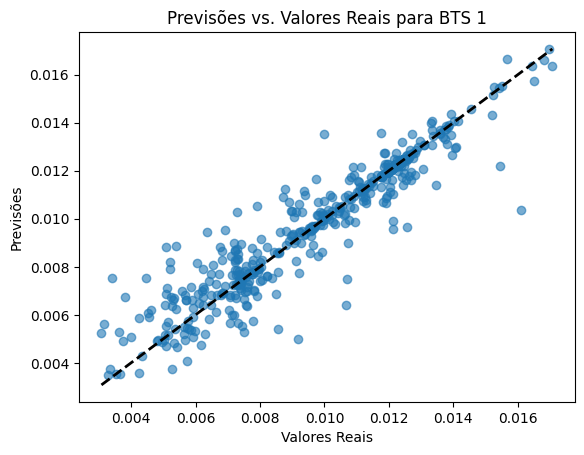

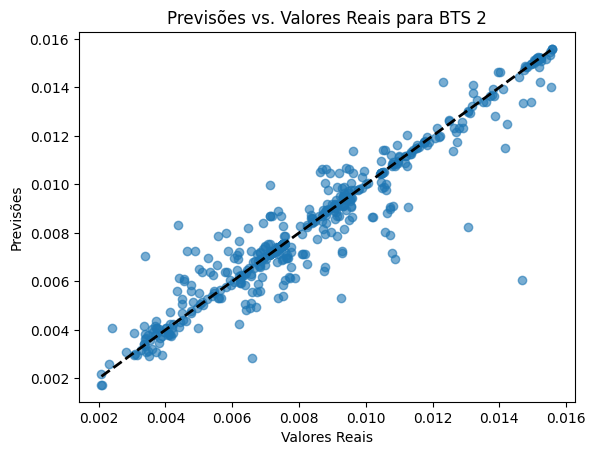

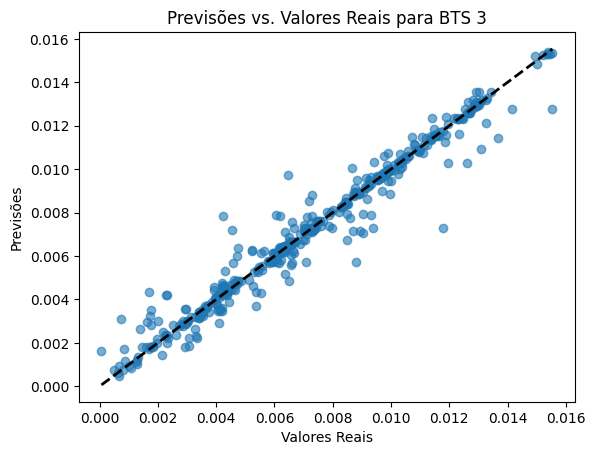

In [36]:
# Exemplo de uso para as BTSs 1, 2 e 3 mockadas
# Armazenando os melhores modelos
models = []
k_values = [i for i in range(1, 10)]
for bts_id in range(1, 4):
    model = knn_regression_and_return_best_model(train, k_values, bts_id)
    models.append(model)

#### Função Trilateração

In [37]:
def trilateration(bts1_pos, bts2_pos, bts3_pos, dist_to_bts1, dist_to_bts2, dist_to_bts3):
    # Ajusta as posições das BTSs para o sistema de coordenadas centrado na BTS1
    p2 = np.array(bts2_pos) - np.array(bts1_pos)
    p3 = np.array(bts3_pos) - np.array(bts1_pos)

    # Calcula os vetores e suas normalizações - formando nossa base ortonormal
    # Cada vetor é unitário e os 3 são mutuamente perpendiculares
    Xn = p2 / np.linalg.norm(p2)
    Zn = np.cross(p2, p3) / np.linalg.norm(np.cross(p2, p3))
    Yn = np.cross(Xn, Zn)

    # Projeções no sistema de coordenadas local
    i = np.dot(Xn, p3)
    d = np.linalg.norm(p2)
    j = np.dot(Yn, p3)

    # Cálculo de X
    X = (pow(dist_to_bts1, 2) - pow(dist_to_bts2, 2) + pow(d, 2)) / (2 * d)
    # Cálculo de Y
    Y = ((pow(dist_to_bts1, 2) - pow(dist_to_bts3, 2) + pow(i, 2) + pow(j, 2)) / (2 * j)) - ((i / j) * X)
    # Cálculo de Z
    Z = np.sqrt(max(0, pow(dist_to_bts1, 2) - pow(X, 2) - pow(Y, 2)))

    # Transforma de volta para o sistema de coordenadas global, considerando a posição da BTS1 como referência
    estimated_pos = np.array(bts1_pos) + X * Xn + Y * Yn + Z * Zn
    return estimated_pos

In [38]:
import numpy as np

def predict_distance(model, rssi, delay):
    return model.predict(np.array([[rssi, delay]]))[0]

def prev_loc(rssi_values, delay_values, models, bts_positions):
    predicted_distances = []
    for i, model in enumerate(models):
        features = np.array([[rssi_values[i], delay_values[i]]]) 

        predicted_distance = model.predict(features)[0]
        predicted_distances.append(predicted_distance)
    
    print(predicted_distances)
    return trilateration(bts_positions[0], bts_positions[1], bts_positions[2], *predicted_distances)

In [76]:
import time

start_time = time.time()

# Separando características (X) e alvos (y)
X = train.iloc[:, :-6]  # Seleciona todas as colunas exceto as três últimas
y = train.iloc[:, -6:-3]  # Seleciona apenas as colunas 'lat' e 'lon'

# # Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=413454523)

# # Inicializando listas para previsões e valores verdadeiros
lat_pred = []
lon_pred = []

lat_true = y_test['lat'].values  # Não precisa converter para float, pois já devem ser floats
lon_true = y_test['lon'].values  # Não precisa converter para float

# # Para cada linha em X_test, fazer previsões baseadas em RSSI e delay
for index, row in X_test.iterrows():
    # Assumindo que a função prev_loc já foi ajustada para aceitar as entradas corretas
    # Aqui você precisará ajustar para passar os modelos corretos e as coordenadas das BTSs
    rssi_values = [row[f'rssi_{i}_2'] for i in range(1, 4)]  # Captura os valores RSSI corretos
    delay_values = [row['delay_1'], row['delay_2'], row['delay_3']]  # Captura os valores de delay

    # Aqui é onde você precisa adaptar para passar os modelos treinados corretos e as posições das BTSs
    # Esta é uma chamada fictícia, pois depende de como você implementou prev_loc e treinou seus modelos KNN
    # pred = prev_loc(rssi_values, delay_values, models, bts_coords)   # Adapte conforme necessário

    # lat_pred.append(pred[0])
    # lon_pred.append(pred[1])

end_time = time.time()
total_time = end_time - start_time

print("Tempo de treinamento e execução:", f'{total_time:.4f}', "segundos")

           lat        lon  indoor
0    -8.055786 -34.951505    True
1    -8.055784 -34.951608    True
2    -8.055506 -34.951693    True
3    -8.050390 -34.959630   False
4    -8.055380 -34.951736    True
...        ...        ...     ...
6770 -8.055784 -34.951608    True
6771 -8.055784 -34.951608    True
6772 -8.055784 -34.951608    True
6773 -8.055380 -34.951736    True
6774 -8.055320 -34.951080   False

[6775 rows x 3 columns]
Tempo de treinamento e execução: 0.0157 segundos
